## 통계 기반 기법 개선하기

###  상호정보량

In [1]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    print("N=",N)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) # 모두 나올 빈도 / (j나올빈도*i나올빈도), eps: 분모 0 방지
            M[i, j] = max(0, pmi) # ppmi

            if verbose: # progress 표시
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
print(C)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
N= 14
동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


###  SVD에 의한 차원의 감소

In [4]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
print(C)
W = ppmi(C)
print(W)
print(W.shape)
# SVD
U, S, V = np.linalg.svd(W) # 넘파이.리니어알제브라.특이값분해 
print(U.shape) # (7, 7)
print(S.shape) # (7, )
print(V.shape) # (7, 7)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]
(7, 7)
(7, 7)
(7,)
(7, 7)


In [5]:
print(C[0])

[0 1 0 0 0 0 0]


In [6]:
print(W[0])

[0.    1.807 0.    0.    0.    0.    0.   ]


In [7]:
print(U[0])
# 특이값 분해를 하면 중요한 값은 왼쪽에 모임

[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]


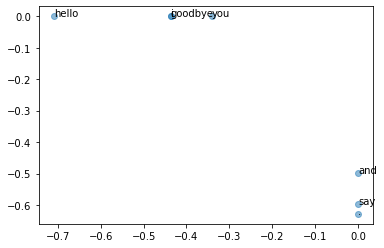

In [8]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1])) # 7열 중 맨 왼쪽인 0열과 1열만 사용 -> 중요한 왼쪽 부분만 사용 
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

# 행렬 압축을 위해 특이값 분해를 해서 어느정도 정보를 손실 시키더라도 큰 차이가 없음

### PTB 데이터셋

In [13]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus)) # 929589
print('corpus[:30]:', corpus[:30]) # 300개로 확인하면 단어들이 중복되는 것을 알 수 있음
print(len(id_to_word)) # vocab 크기: 10000 => 즉, 만 개의 단어를 정의했다는 뜻 같음! 영어에선 만개면 웬만한 문장 다 가능 
# id에 대응하는 단어 확인
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
# 단어에 해당하는 id 확인
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
10000
id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### PTB 데이터셋 평가

In [15]:
import sys
sys.path.append('..') # 부모 디렉토리로 패스를 걸겠다는 뜻. 왜냐면 소스 디렉토리의 common, dataset을 받아야 하므로.
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print(C.shape) # (10000, 10000)
print(C[100, :100])
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)
print(W.shape)
print(W[100, :100])

'''print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size] # 10000개 열 전부 필요 없으니 wordvec_size(100)만큼만 쓰겠다. <= 압축

querys = ['you', 'year', 'car', 'toyota'] # 이것들과 비슷한 단어 추출
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)'''

동시발생 수 계산 ...
(10000, 10000)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  80   0 120  16   0   1   8   0 173   1   3 152
   0   0   0   9  40   0 174   1   2   1   3   0  24   0   0   0   0   1
  10   1   6   3   1   0   0   0   0   0  41   1   0   0   0  20   1   0
   0   0   0   0   0   0  12   0   0   0   0   4   0   0   0   5   1   0
   0   0   0  16   0   0   0   1  21  29]
PPMI 계산 ...


C:\Users\XIUMIN\Desktop\R=VD대기업이직성공\AI_NLP_ADVANCED\소스_1\ch02\..\common\util.py:141: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\XIUMIN\Desktop\R=VD대기업이직성공\AI_NLP_ADVANCED\소스_1\ch02\..\common\util.py:141: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
(10000, 10000)
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.  